In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

import statsmodels.api as sm
from io import StringIO
import ges
import lingam
from lingam.utils import make_dot

from pgmpy.estimators import PC

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read file and remove unnecessary columns

In [3]:
# Read xlsx file and save in a pandas dataframe
full_df = pd.read_excel('metabolomics_negative_mode-serum.xlsx', sheet_name='Sheet1')
full_df.columns
columns_to_remove = ['Ions', 'Name', 'Molecular Formula', 'Structure', 'MS/MS score', 'ΔCCS [%]', 'mSigma', 'Annotations', 'Annotation Source', 
                     'Flags', 'AQ', 'Δm/z [ppm]', 'Include', 'MS/MS']

# Remove columns that are not needed
df = full_df
df = df.drop(columns=columns_to_remove)
df

,RT [min],m/z meas.,M meas.,CCS (Å²),Boxplot,Mob. 1/K0,Blank_31_1_7720,10ul sample_32_1_7721,10ul sample_33_1_7722,10ul sample_34_1_7723,Blank_43_1_7724,25ul sample_44_1_7725,25ul sample_45_1_7726,25ul sample_46_1_7727,Blank_43_1_7728
0,0.38,116.92817,117.93544,108.2,5190.851562,0.485,0,5191,4920,6379,5597,0,6812,5055,7534
1,0.88,208.06458,209.07186,148.0,0.000000,0.694,3462,0,0,0,2903,0,0,0,2736
2,0.94,601.97961,602.98688,180.8,16577.728516,0.882,21600,15121,13980,16302,17786,17786,16578,16958,16420
3,0.94,242.94316,243.95044,145.9,1419.936401,0.690,1809,1877,0,963,1420,1312,2159,1294,1931
4,0.94,615.99432,617.00159,184.0,2323.567139,0.899,2059,2827,2277,1937,2555,2506,2150,2809,2324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,16.93,320.88628,321.89355,167.9,6566.890137,0.804,8836,5760,6567,5315,5301,8056,8279,5743,7724
341,16.92,320.88729,321.89457,180.6,3094.479248,0.865,2787,1744,3094,2301,3163,4933,7098,2827,3801
342,16.93,190.92850,191.93577,145.5,106593.351562,0.678,118767,106226,96391,101821,106593,134170,126165,102646,125296
343,16.93,336.85863,337.86591,166.6,11204.254883,0.799,11883,7847,11100,11204,10425,12043,13923,11041,12032


# Basic Explorative Analysis

## Correlation Matrix

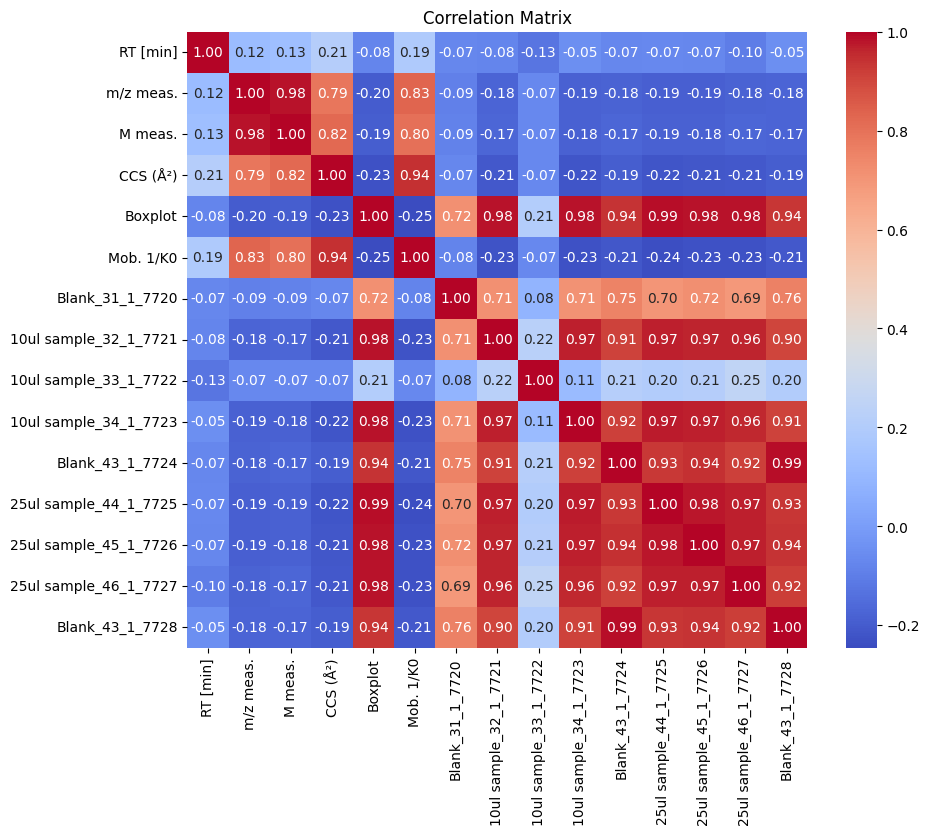

In [4]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


## Histogram

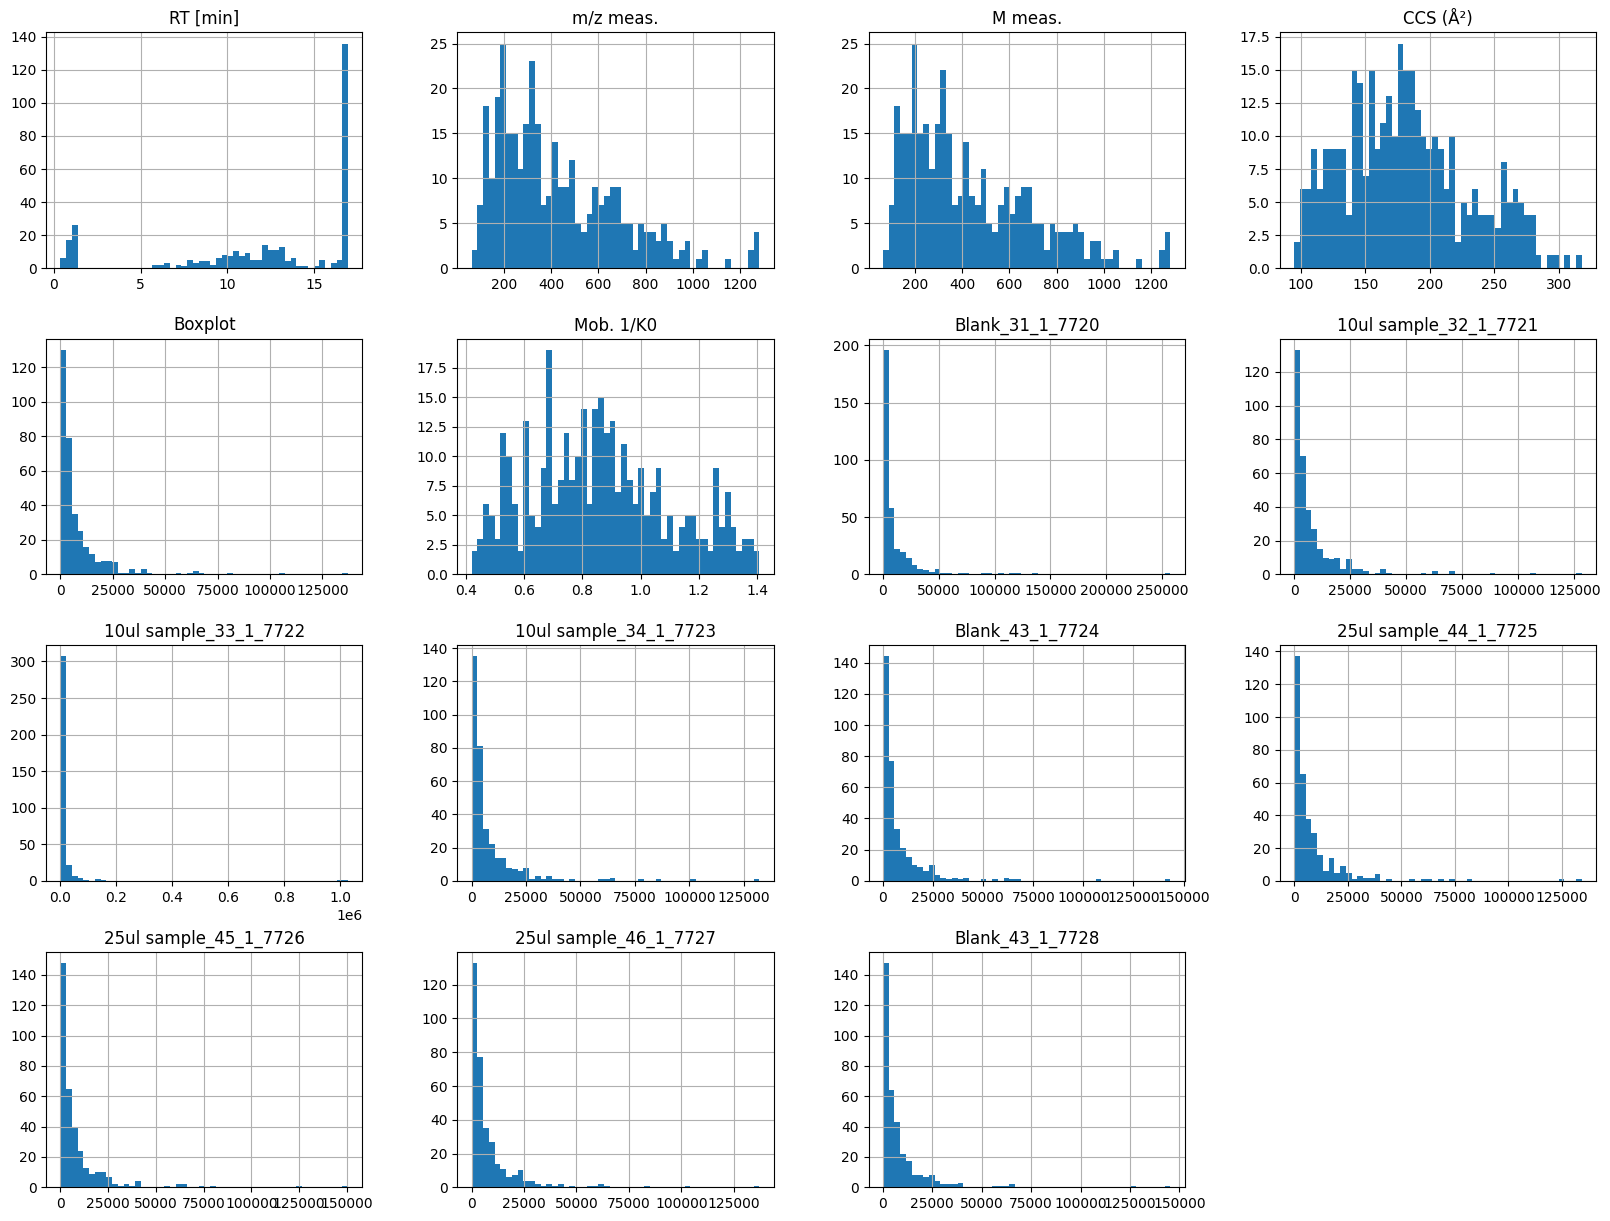

In [5]:
# plot the histogram of the data
df.hist(bins=50, figsize=(20,15))
plt.show()

## Covariance Matrix

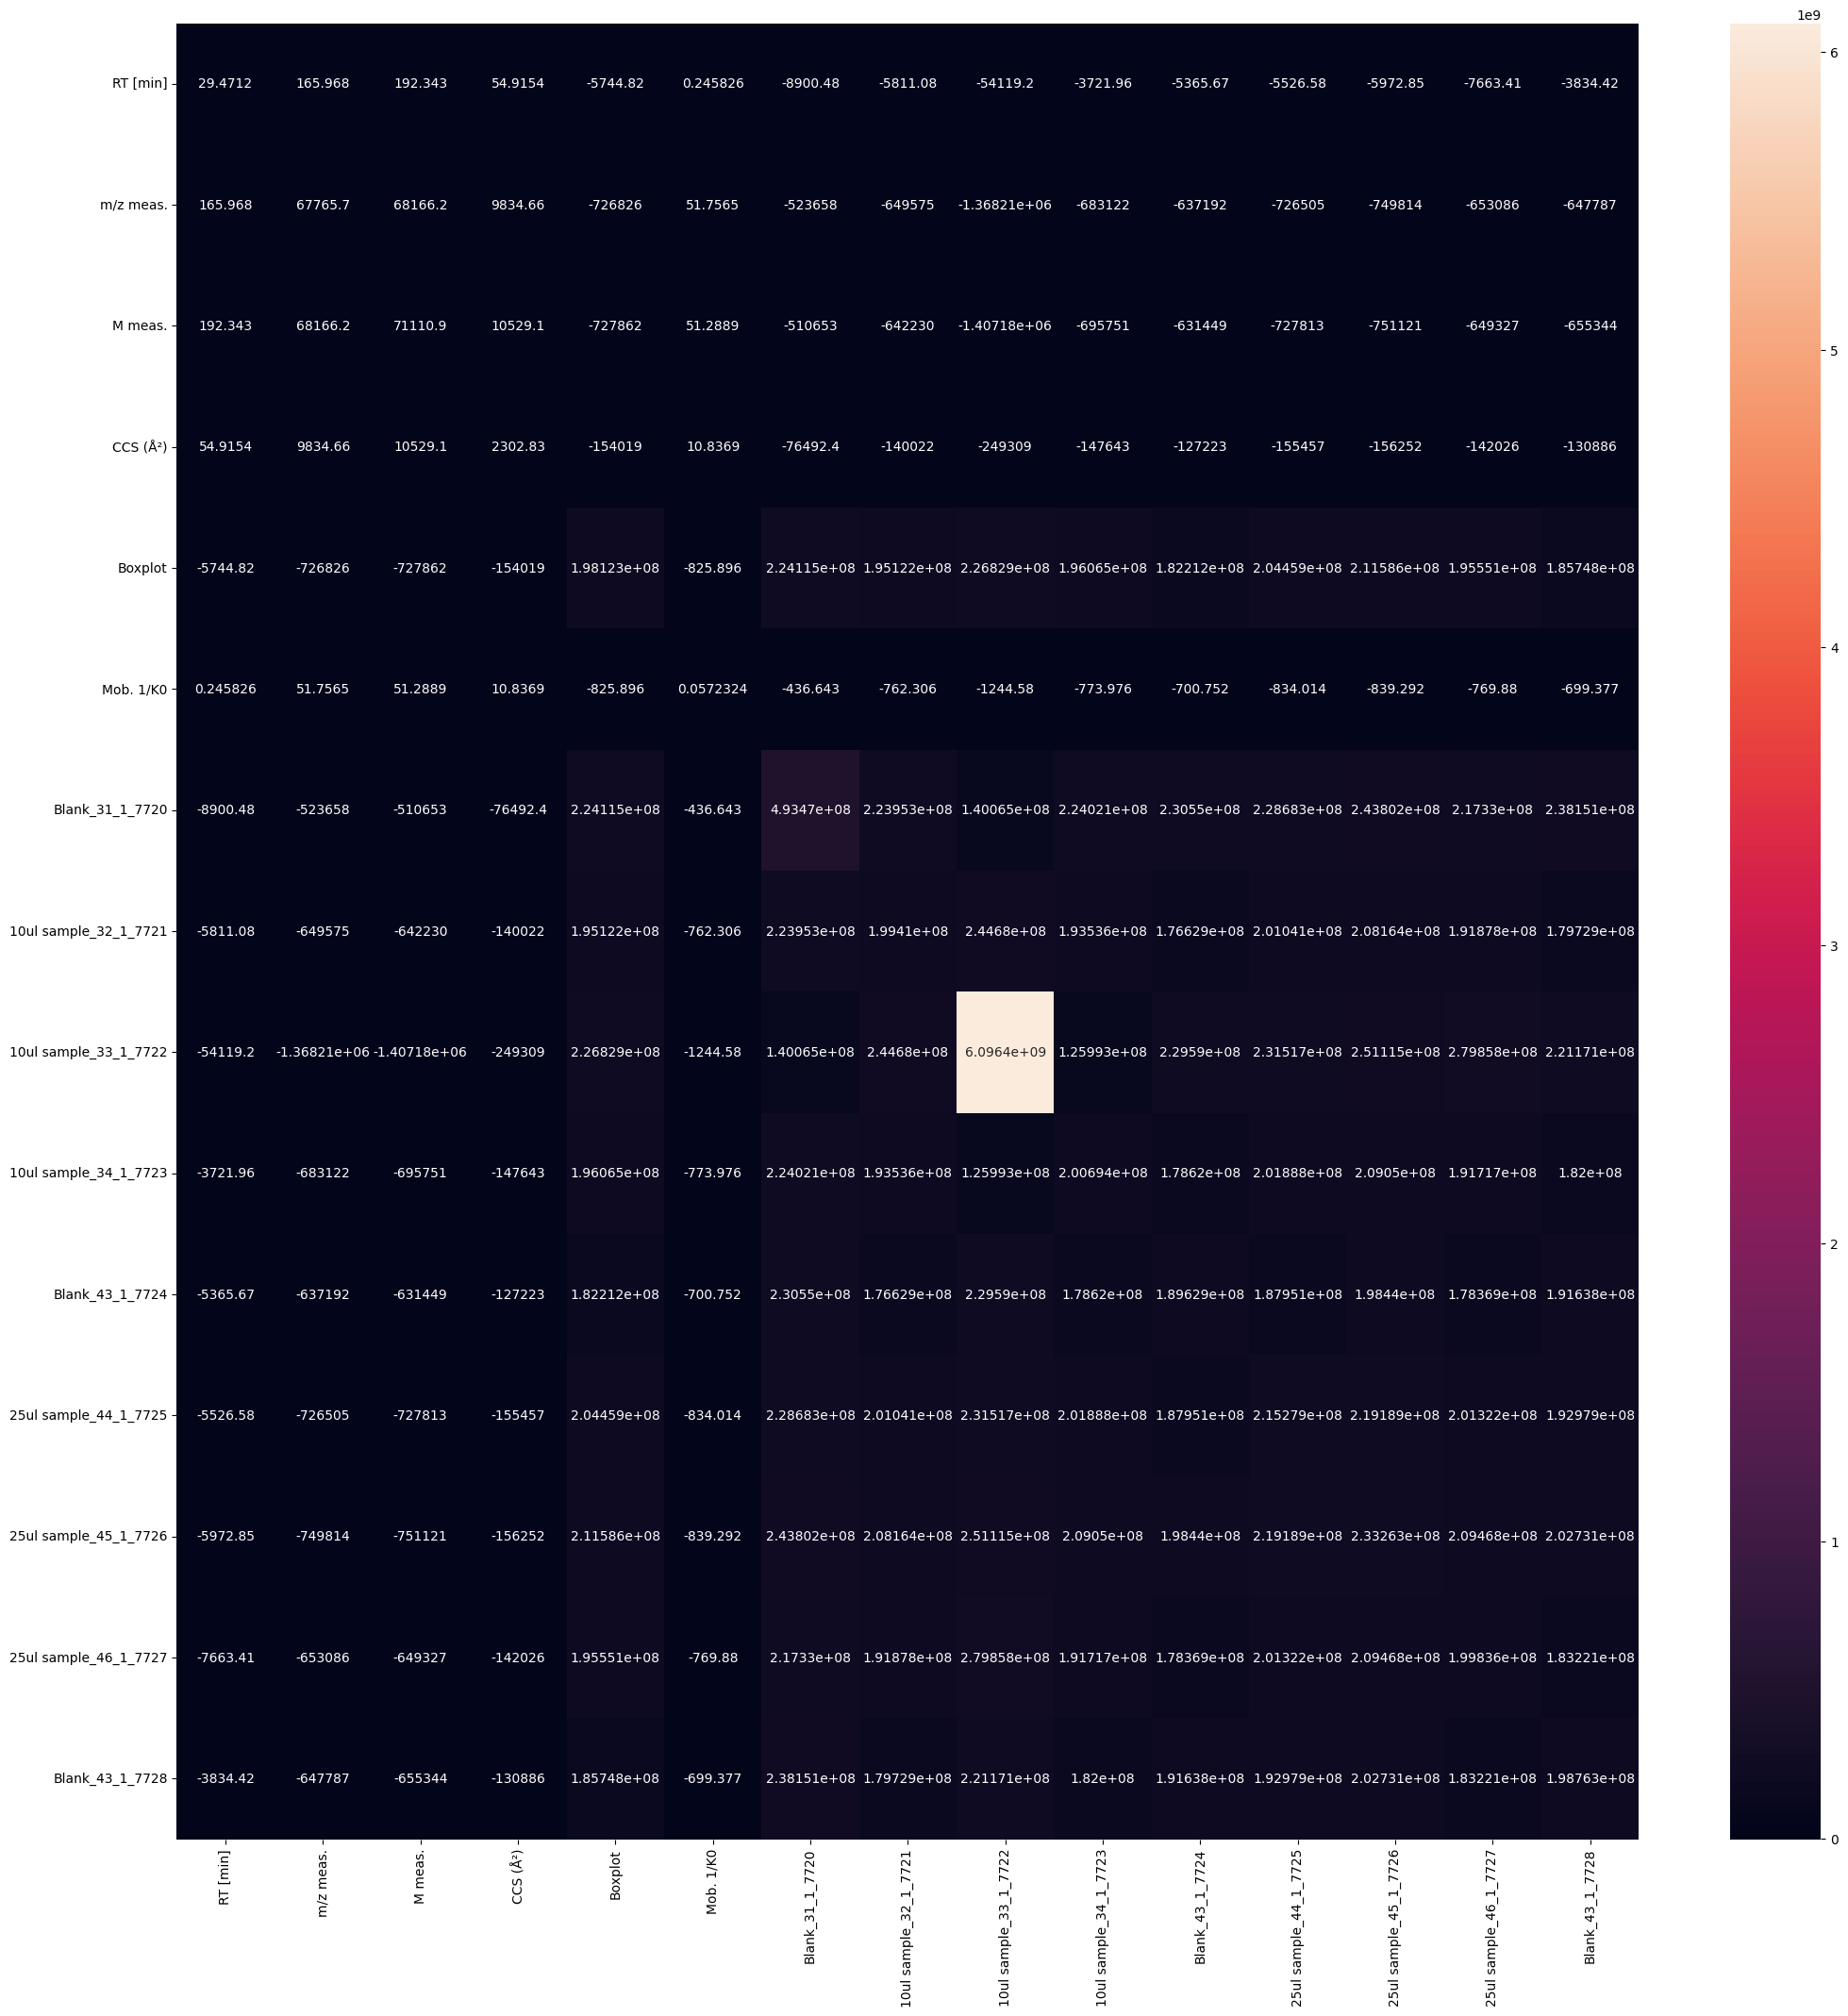

In [6]:
#covariance matrix of the data
cov_matrix = df.cov()
plt.figure(figsize=(25,25))
sns.heatmap(cov_matrix, annot=True, fmt='g')

plt.show()


# PC algorithm for Causal DAG - FAILED SPECTACULARLY!!!

Working for n conditional variables: 2:  40%|████      | 2/5 [00:04<00:06,  2.06s/it]


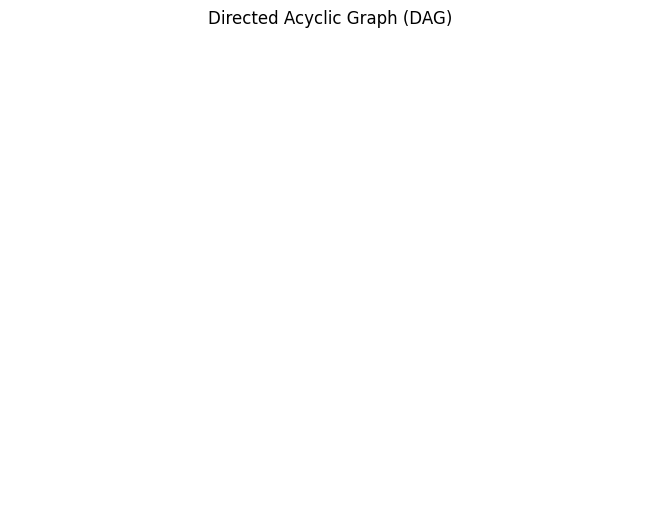

In [7]:
pc = PC(df)
model = pc.estimate()

edges = model.edges()

# Create a directed graph using networkx
G = nx.DiGraph(edges)

# Visualize the DAG
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, arrowsize=20, node_size=700, node_color="skyblue", font_size=10, font_color="black")

# Show the plot
plt.title("Directed Acyclic Graph (DAG)")
plt.show()

# Park's Algorithm

Consider df with columns A, B, C, D.
Take variable A, regress with B, C, D together. Pick the significant ones (P value < 5%) then compare their variances to see which affects which.

In [16]:
def LM(X, Y):
    X = sm.add_constant(X)
    model = sm.OLS(Y, X)
    model_result = model.fit()
    p_values = model_result.summary().tables[1].as_csv()
    tmp = StringIO(p_values)
    p_values_df = pd.read_csv(tmp, sep=',', skipinitialspace=True)
    p_values_df = p_values_df.rename(columns = {"Unnamed: 0" : "Variable"})
    p_values_df = p_values_df.rename(columns = {"P>|t| " : "P"})
    # print(p_values_df)
    return p_values_df

# Reading the Data
# data = pd.read_csv('a1_data.csv')
data = df
variance = data.var()

# Initializing the adjancency matrix with all zeros
column_names = data.columns.tolist()
out_data = pd.DataFrame(0, index=column_names, columns=column_names)
# print(out_data.head())
# Going across each feature(variable) in the dataset
for col in data:
    data2 = data.drop(col, axis=1)
    # calculating the p-value for each feature by running the linear regression using the other features - 
    # for example, for variable A - the regressors are B, C, D,..., K
    # and we get the p-value for each variable to get the significance.
    p_values_df = LM(data2, data[col])

    # Extracting the edges which have a p_value lesser than 0.05 (5%, standard)
    # to get the variables which have some correlation to the target regressor ('A' in this case)
    no_edge = p_values_df.query('P < 0.05')['Variable']
    for val in no_edge.values:
        if val.split()[0] == 'const':
            continue
        val = ' '.join(val.split())

        # If var(A) < var(D)
        #   then A -> D
        # else
        #   A <- D
        if variance[col] < variance[val]:
            out_data.loc[col, val] = 1
        else:
            out_data.loc[val, col] = 1
# save output to csv
# out_data.to_csv('output.csv')
# print(out_data)


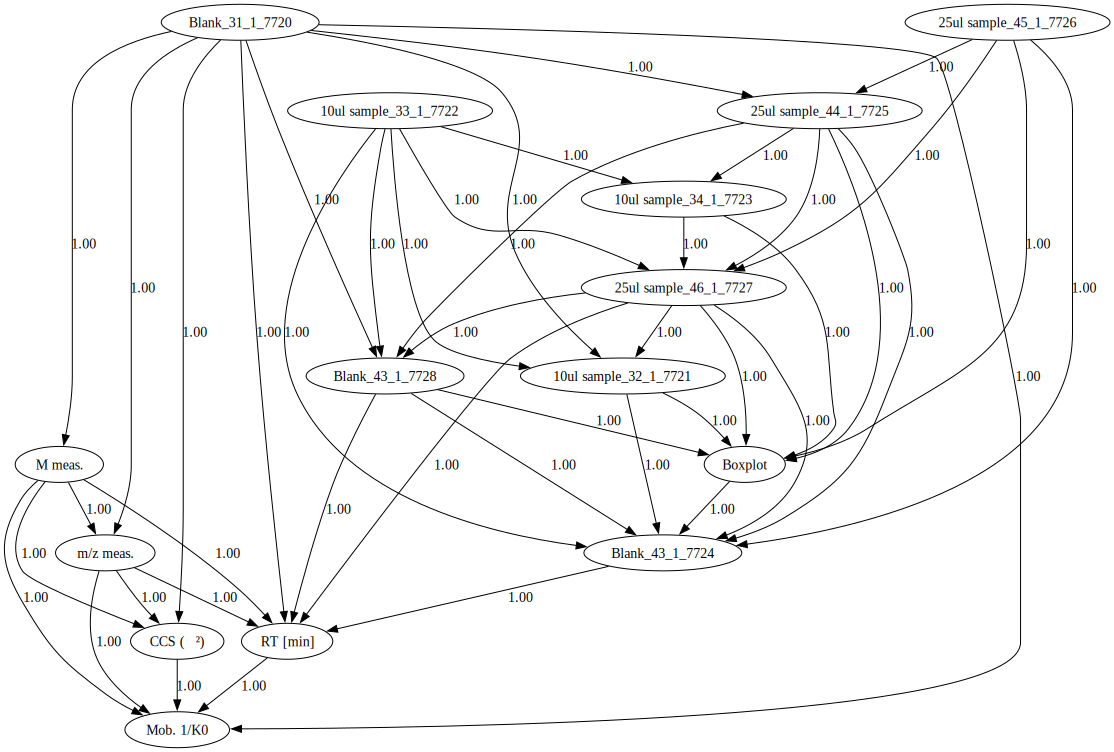

In [15]:
make_dot(out_data, labels=df.columns.to_list())

# Direct LiNGAM

In [48]:
# Model Creation
model = lingam.DirectLiNGAM()
model.fit(df)

In [49]:
model.causal_order_

[14, 8, 10, 4, 7, 9, 13, 6, 11, 12, 0, 5, 3, 2, 1]

In [50]:
model.adjacency_matrix_

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  9.64017730e-01,
        -3.00429181e+00,  0.00000000e+00,  6.10359371e+02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  8.86802492e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         3.25900539e+00,  0.00000000e+00,  2.79061775e+02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.89348983

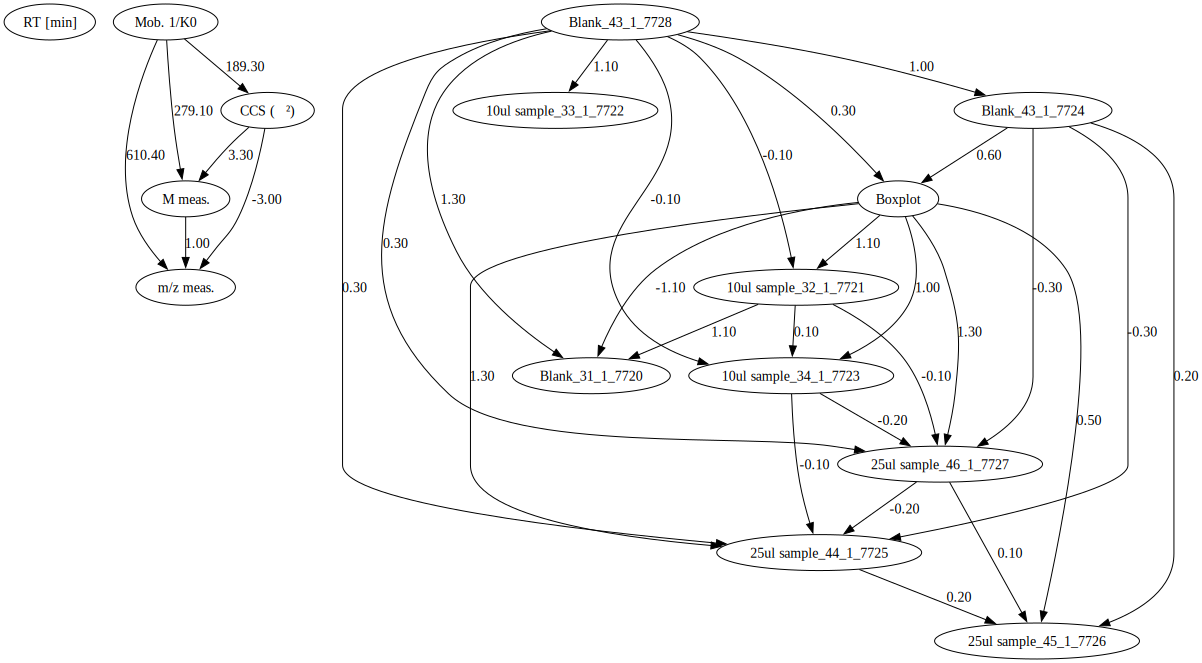

In [72]:
make_dot(model.adjacency_matrix_.round(1), labels=df.columns.to_list())

In [52]:
FinalDAG=pd.DataFrame(data=model.adjacency_matrix_.round(1),columns=data.columns,index=data.columns)
FinalDAG.abs().values

array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 6.104e+02,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 3.300e+00, 0.000e+00, 2.791e+02,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.893e+02,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 6.000e-01, 0.000e+00,
        0.000e+00, 0.000e+00, 3.000e-01],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00

# GES (Greedy Equivalence Search) Algorithm for DAG

In [77]:
estimate, score = ges.fit_bic(df.to_numpy(), A0 = None, phases = ['forward', 'backward', 'turning'], debug = 0)
print(estimate, score)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0 1 1 1 1 1]
 [0 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 0 0 0 0 1 1]
 [0 0 0 0 1 0 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 1 0 1]
 [0 0 1 0 0 0 1 1 0 0 0 0 0 0 0]] -35602.83431702955


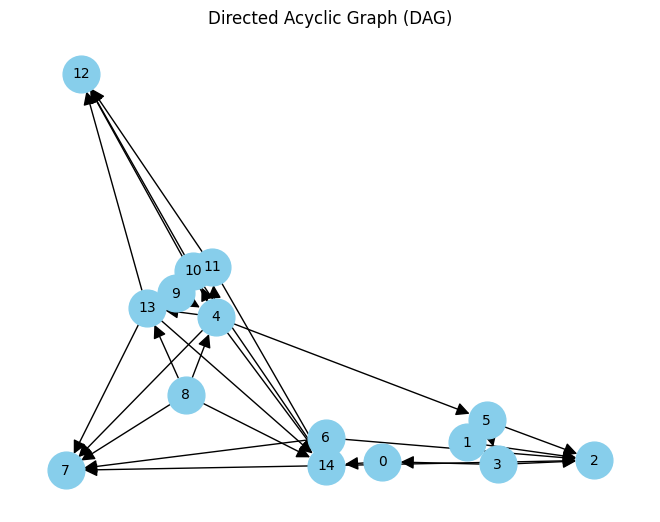

In [80]:
G = nx.DiGraph(estimate)
pos = nx.spring_layout(G)

nx.draw(G, pos, with_labels=True, arrowsize=20, node_size=700, node_color="skyblue", font_size=10, font_color="black")
plt.title("Directed Acyclic Graph (DAG)")
plt.show()
